Found 2052 validated image filenames belonging to 5 classes.
Found 684 validated image filenames belonging to 5 classes.
Found 684 validated image filenames belonging to 5 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 105s 949ms/step - accuracy: 0.2681 - loss: 1.6116 - val_accuracy: 0.3070 - val_loss: 1.6142 - learning_rate: 5.0000e-04
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 30s 427ms/step - accuracy: 0.4178 - loss: 1.3559 - val_accuracy: 0.3933 - val_loss: 1.5156 - learning_rate: 5.0000e-04
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 30s 421ms/step - accuracy: 0.4627 - loss: 1.2964 - val_accuracy: 0.4079 - val_loss: 1.3588 - learning_rate: 5.0000e-04
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 30s 418ms/step - accuracy: 0.5044 - loss: 1.2068 - val_accuracy: 0.5249 - val_loss: 1.1377 - learning_rate: 5.0000e-04
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 30s 422ms/step - accuracy: 0.5409 - loss: 1.1483 - val_accuracy: 0.5746 - val_loss: 1.0521 - learning_rate: 5.0000e-04
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 30s 420ms/step - accuracy: 0.5407 - loss: 1.1762 - val_accuracy: 0.5804 - val_loss: 0.9813 - learning_rate: 5.0000e-04
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 29s 411ms/step - accuracy: 0.5

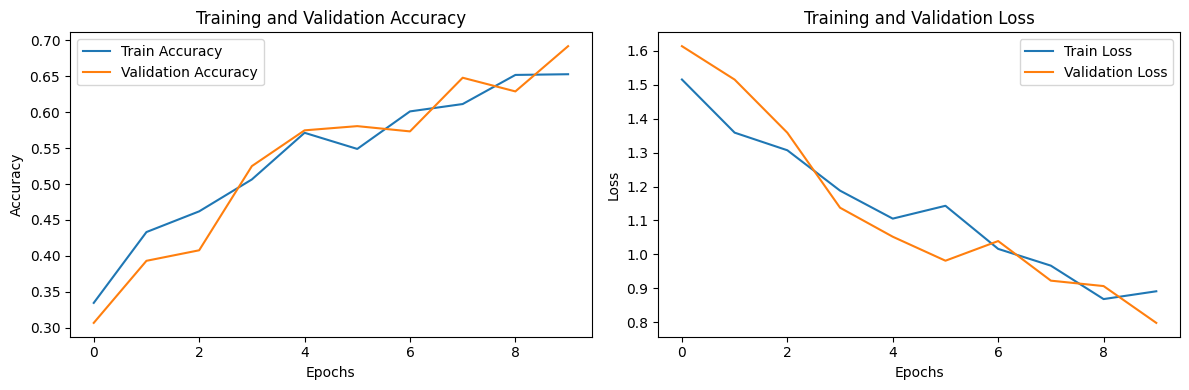

22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 408ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


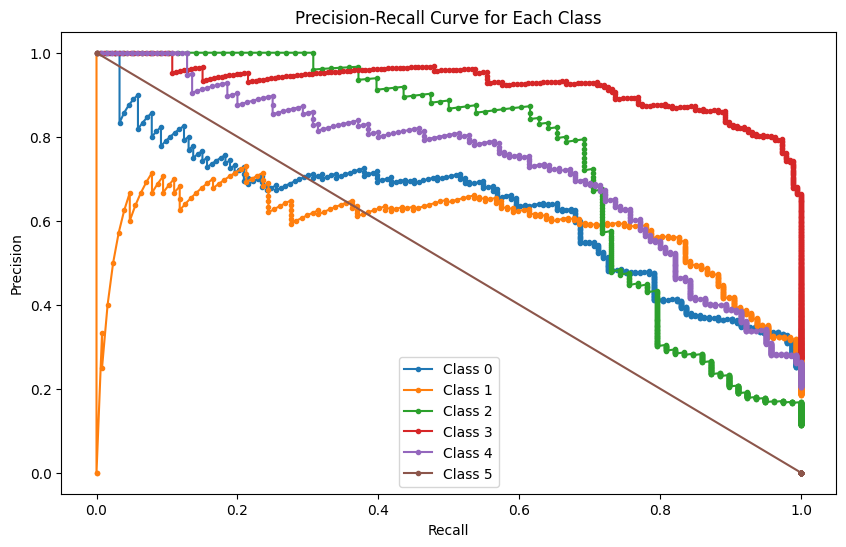


Model saved successfully!


In [2]:
import os
import cv2
import numpy as np
import random
import albumentations as A
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import AveragePooling2D, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_curve

# Disable version check for albumentations
import albumentations.core.utils
albumentations.core.utils.check_version = lambda: None

# Set dataset paths
dataset_path = "/kaggle/input/thermal-images-diseased-healthy-leaves-paddy/thermal images UL"
output_path = "/kaggle/working/expanded_dataset"
final_dataset_path = "/kaggle/working/final_processed_dataset"

# Ensure only valid labels are considered
valid_labels = {"BLB", "Blast", "healthy", "hispa", "leaf folder", "leaf spot"}

# Create necessary directories
os.makedirs(output_path, exist_ok=True)
os.makedirs(final_dataset_path, exist_ok=True)

# Define augmentations
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.3),
    A.RandomResizedCrop(height=224, width=224, scale=(0.7, 1.0), p=0.5),
    A.GridDistortion(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5)
])

def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    return cv2.cvtColor(cv2.merge((l, a, b)), cv2.COLOR_LAB2BGR)

def apply_filtering(img):
    return cv2.medianBlur(cv2.GaussianBlur(img, (5, 5), 0), 5)

def apply_thresholding(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)

def apply_morphology(img):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool):
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    
    conv_3x3_reduce = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3_reduce)
    
    conv_5x5_reduce = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5_reduce)
    
    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(pool_proj)
    
    output = Concatenate(axis=-1)([conv_1x1, conv_3x3, conv_5x5, pool_proj])
    return output

def build_googlenet(input_shape, num_classes):
    inputs = Input(input_shape)
    
    # Initial convolutions
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # Inception modules
    x = inception_module(x, 64, 96, 128, 16, 32, 32)
    x = inception_module(x, 128, 128, 192, 32, 96, 64)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    x = inception_module(x, 192, 96, 208, 16, 48, 64)
    x = inception_module(x, 160, 112, 224, 24, 64, 64)
    x = inception_module(x, 128, 128, 256, 24, 64, 64)
    x = inception_module(x, 112, 144, 288, 32, 64, 64)
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    x = inception_module(x, 256, 160, 320, 32, 128, 128)
    x = inception_module(x, 384, 192, 384, 48, 128, 128)
    
    # Classification head
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Dataset expansion
for label in os.listdir(dataset_path):
    if label not in valid_labels:
        continue
    label_path = os.path.join(dataset_path, label)
    save_path = os.path.join(output_path, label)
    os.makedirs(save_path, exist_ok=True)
    
    images = [os.path.join(label_path, img) for img in os.listdir(label_path)]
    
    while len(images) < 220:
        img_path = random.choice(images)
        try:
            img = cv2.imread(img_path)
            if img is None:
                continue
            augmented = augmentations(image=img)["image"]
            cv2.imwrite(os.path.join(save_path, f"aug_{len(images)}.jpg"), augmented)
            images.append(img_path)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

# Apply processing techniques
for label in os.listdir(output_path):
    if label not in valid_labels:
        continue
    label_path = os.path.join(output_path, label)
    save_label_path = os.path.join(final_dataset_path, label)
    os.makedirs(save_label_path, exist_ok=True)
    
    for img_file in os.listdir(label_path):
        try:
            img_path = os.path.join(label_path, img_file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            
            cv2.imwrite(os.path.join(save_label_path, f"orig_{img_file}"), img)
            cv2.imwrite(os.path.join(save_label_path, f"clahe_{img_file}"), apply_clahe(img))
            cv2.imwrite(os.path.join(save_label_path, f"filtered_{img_file}"), apply_filtering(img))
            cv2.imwrite(os.path.join(save_label_path, f"thresh_{img_file}"), apply_thresholding(img))
            cv2.imwrite(os.path.join(save_label_path, f"morph_{img_file}"), apply_morphology(img))
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
            continue

# Data loading and splitting
all_images, all_labels = [], []
label_map = {label: idx for idx, label in enumerate(valid_labels)}

for label in valid_labels:
    label_path = os.path.join(final_dataset_path, label)
    if not os.path.exists(label_path):
        continue
    for img_file in os.listdir(label_path):
        img_path = os.path.join(label_path, img_file)
        if os.path.exists(img_path):
            all_images.append(img_path)
            all_labels.append(label_map[label])

if not all_images:
    raise Exception("No valid images found in the dataset")

# Data splitting
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(all_images, all_labels, test_size=0.4, stratify=all_labels, random_state=42)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(temp_imgs, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(all_labels), y=all_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Convert labels to strings
train_labels = list(map(str, train_labels))
val_labels = list(map(str, val_labels))
test_labels = list(map(str, test_labels))

# Enhanced data generator with additional augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Data generators
train_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": train_imgs, "class": train_labels}),
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse"
)

val_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": val_imgs, "class": val_labels}),
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse"
)

test_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": test_imgs, "class": test_labels}),
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",
    shuffle=False
)

# Create and compile model with modified learning rate
model = build_googlenet((224, 224, 3), len(valid_labels))
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Reduced learning rate for better stability
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Add callbacks for better training
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True
    )
]

# Training with error handling
try:
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,  # Increased to 10 epochs
        class_weight=class_weight_dict,
        callbacks=callbacks
    )

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(test_gen)
    print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")
    print(f"Final Test Loss: {test_loss:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.tight_layout()
    plt.show()

    # Compute and plot PR curve
    num_classes = len(valid_labels)
    y_true = tf.keras.utils.to_categorical(test_gen.classes, num_classes)
    y_probs = model.predict(test_gen)

    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
        plt.plot(recall, precision, marker='.', label=f'Class {i}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Each Class')
    plt.legend()
    plt.show()

    # Save the model
    model.save('googlenet_leaf_disease_10epochs.h5')
    print("\nModel saved successfully!")

except Exception as e:
    print(f"An error occurred during training: {e}")